# Introducción

En este notebook realizaremos un análisis exploratorio y estadístico de dos variables oceánicas clave en la zona costera occidental del Golfo de California:

1. **Temperatura Superficial del Mar (TSM)**  
   – Periodo de estudio: **enero 1981 – diciembre 2018**  
   – Objetivo: caracterizar su variabilidad interanual, intranual y estacional, y encontrar sus frecuencias dominantes de oscilación.

2. **Concentración de Clorofila a (Chl a)**  
   – Periodo de estudio: **enero 1997 – diciembre 2018**  
   – Objetivo: cuantificar su variabilidad temporal y determinar sus ciclos de variación principales.

Además, profundizaremos en:

- **Regionalización** de la costa noroeste de México, agrupando subregiones con comportamientos climatológicos similares, mediante técnicas de reducción de dimensionalidad y clustering multivariante.
- **Efecto del ENSO** (El Niño–Oscilación del Sur):  
  - Cartografía de fases ENSO (Niño, Neutro, Niña) sobre los datos.  
  - Comparación de medias y varianzas de TSM y Chl a en cada fase.  
  - Análisis estacional dentro de cada fase para detectar respuesta diferencial en ciclos anuales.

**Metodología general**:  
1. **Carga y limpieza** de datos temporales.  
2. **Cómputo de estadísticos descriptivos** (media, desviación estándar, percentiles).  
3. **Análisis de frecuencias** vía periodograma para identificar ciclos dominantes (p.ej. anual, semestral).  
4. **Regionalización** usando PCA + k-means (o DBSCAN) aplicado a indicadores multivariados TSM–Chl a.  
5. **Análisis ENSO**: unión con índice ONI, segmentación por fase, pruebas estadísticas (ANOVA/Kruskal–Wallis), y visualizaciones comparativas (boxplots, series descompuestas).

A continuación implementaremos paso a paso estas etapas en Python, apoyándonos en librerías como `pandas`, `numpy`, `scipy`, `scikit-learn` y `statsmodels`. 

In [38]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis de series de tiempo
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import seasonal_decompose

# Estadística y pruebas
from scipy.stats import f_oneway, kruskal

# Reducción de dimensionalidad y clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

# Georreferenciación y mapeo (para regionalización)
import geopandas as gpd
import folium

from pathlib import Path
from prophet import Prophet 

In [ ]:
ruta_actual = Path.cwd()
PROJECT_DIR = ruta_actual.parents[1]
PROCESSED_DIR     = PROJECT_DIR / 'data' / 'interim'

In [ ]:
df = pd.read_csv(PROCESSED_DIR / 'data.csv')

In [41]:
df.head()

,fecha,estacion,tsm,ano,mes,chla,mes_num,est_index,longitud,latitud,evento,oni,estacion_climatica
0,1981-09-01,est_1,30.5000,NaN,9,NaN,NaN,0.0,-109.3,23.8,Neutro,-0.2,SON
1,1981-09-01,est_10,28.6250,NaN,9,NaN,NaN,9.0,-112.3,27.6,Neutro,-0.2,SON
2,1981-09-01,est_11,29.1583,NaN,9,NaN,NaN,10.0,-112.6,28.0,Neutro,-0.2,SON
3,1981-09-01,est_12,28.8750,NaN,9,NaN,NaN,11.0,-112.9,28.5,Neutro,-0.2,SON
4,1981-09-01,est_13,26.9667,NaN,9,NaN,NaN,12.0,-113.2,28.9,Neutro,-0.2,SON


In [42]:
# 1. Inspección básica
print(df.shape)        # filas × columnas
print(df.dtypes)       # confirma que 'fecha' es datetime y revisa tipos de otras columnas
print(df.head(5))      # primeras 5 filas para ver la estructura de datos
print(df.isna().sum()) # cuántos valores faltan en cada columna

(7582, 13)
fecha                  object
estacion               object
tsm                   float64
ano                   float64
mes                     int64
chla                  float64
mes_num               float64
est_index             float64
longitud              float64
latitud               float64
evento                 object
oni                   float64
estacion_climatica     object
dtype: object
        fecha estacion      tsm  ano  mes  chla  mes_num  est_index  longitud  \
0  1981-09-01    est_1  30.5000  NaN    9   NaN      NaN        0.0    -109.3   
1  1981-09-01   est_10  28.6250  NaN    9   NaN      NaN        9.0    -112.3   
2  1981-09-01   est_11  29.1583  NaN    9   NaN      NaN       10.0    -112.6   
3  1981-09-01   est_12  28.8750  NaN    9   NaN      NaN       11.0    -112.9   
4  1981-09-01   est_13  26.9667  NaN    9   NaN      NaN       12.0    -113.2   

   latitud  evento  oni estacion_climatica  
0     23.8  Neutro -0.2                SON  
1     27

In [43]:
# Convertir la columna fecha en datatime
df["fecha"] = pd.to_datetime(df["fecha"])

In [44]:
print(df.dtypes)  

fecha                 datetime64[ns]
estacion                      object
tsm                          float64
ano                          float64
mes                            int64
chla                         float64
mes_num                      float64
est_index                    float64
longitud                     float64
latitud                      float64
evento                        object
oni                          float64
estacion_climatica            object
dtype: object


In [45]:
tsm = df[(df['fecha'].dt.year >= 1981) & (df['fecha'].dt.year <= 2018)]
chla = df[(df['fecha'].dt.year >= 1997) & (df['fecha'].dt.year <= 2018)].dropna()

In [46]:
tsm

,fecha,estacion,tsm,ano,mes,chla,mes_num,est_index,longitud,latitud,evento,oni,estacion_climatica
0,1981-09-01,est_1,30.5000,NaN,9,NaN,NaN,0.0,-109.3,23.8,Neutro,-0.2,SON
1,1981-09-01,est_10,28.6250,NaN,9,NaN,NaN,9.0,-112.3,27.6,Neutro,-0.2,SON
2,1981-09-01,est_11,29.1583,NaN,9,NaN,NaN,10.0,-112.6,28.0,Neutro,-0.2,SON
3,1981-09-01,est_12,28.8750,NaN,9,NaN,NaN,11.0,-112.9,28.5,Neutro,-0.2,SON
4,1981-09-01,est_13,26.9667,NaN,9,NaN,NaN,12.0,-113.2,28.9,Neutro,-0.2,SON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7577,2018-10-01,est_5,29.0756,2018.0,10,0.2772,10.0,4.0,-110.8,25.3,Niño,0.8,SON
7578,2018-10-01,est_6,28.6689,2018.0,10,0.3656,10.0,5.0,-111.1,25.8,Niño,0.8,SON
7579,2018-10-01,est_7,28.7222,2018.0,10,0.5083,10.0,6.0,-111.2,26.3,Niño,0.8,SON
7580,2018-10-01,est_8,28.4456,2018.0,10,0.5119,10.0,7.0,-111.5,26.8,Niño,0.8,SON


In [47]:
print("TSM (1981–2018):")
print(tsm['tsm'].describe(), "\n")

TSM (1981–2018):
count    7582.000000
mean       24.281074
std         4.764086
min        10.368800
25%        20.175000
50%        24.325000
75%        28.734575
max        39.300000
Name: tsm, dtype: float64 



In [48]:
print("Clorofila a (1997–2018):")
print(chla['chla'].describe(), "\n")

Clorofila a (1997–2018):
count    4318.000000
mean        1.213277
std         1.012386
min         0.109800
25%         0.496325
50%         0.968050
75%         1.616625
max         9.067800
Name: chla, dtype: float64 



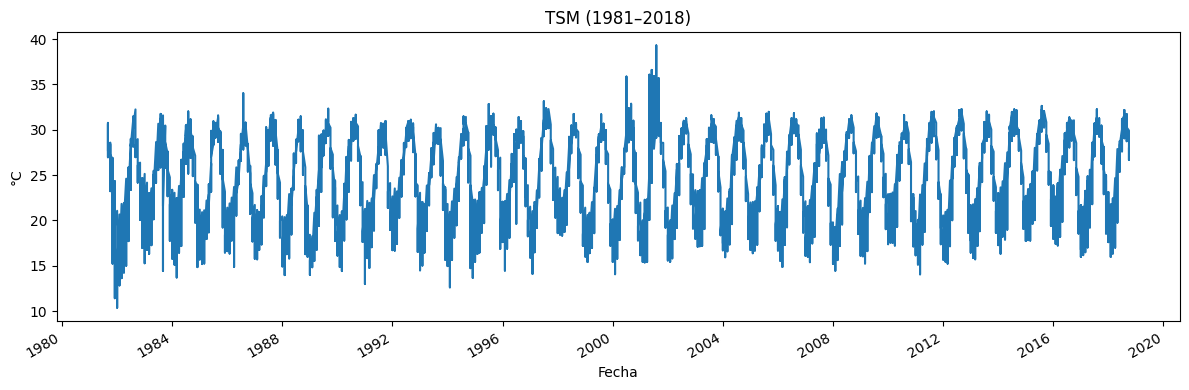

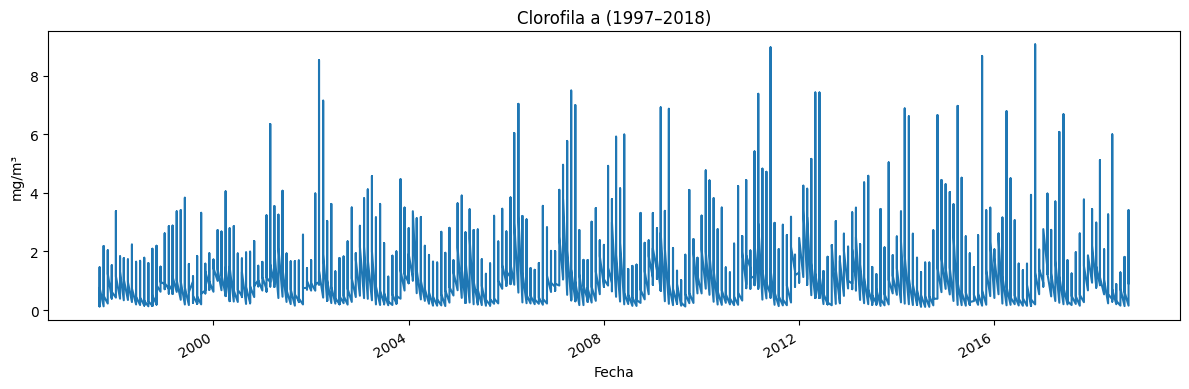

In [61]:
plt.figure(figsize=(12,4))
plt.plot(tsm['fecha'], tsm['tsm'])
plt.title('TSM (1981–2018)')
plt.xlabel('Fecha')
plt.ylabel('°C')
plt.gcf().autofmt_xdate()   # formatea fechas en el eje x
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(chla['fecha'], chla['chla'])
plt.title('Clorofila a (1997–2018)')
plt.xlabel('Fecha')
plt.ylabel('mg/m³')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

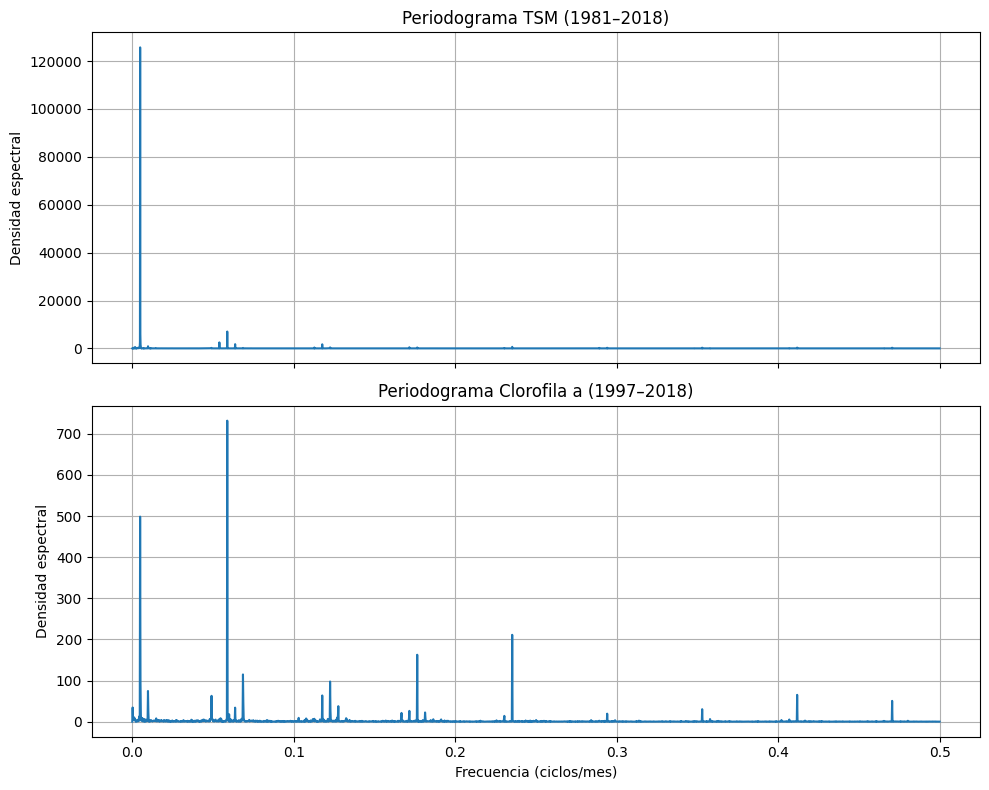

In [62]:
f_tsm, Pxx_tsm   = periodogram(tsm['tsm'], fs=1, detrend='linear')
f_chla, Pxx_chla = periodogram(chla['chla'], fs=1, detrend='linear')

# 5. Graficar periodogramas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(f_tsm, Pxx_tsm)
ax1.set_title('Periodograma TSM (1981–2018)')
ax1.set_ylabel('Densidad espectral')
ax1.grid(True)

ax2.plot(f_chla, Pxx_chla)
ax2.set_title('Periodograma Clorofila a (1997–2018)')
ax2.set_xlabel('Frecuencia (ciclos/mes)')
ax2.set_ylabel('Densidad espectral')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [63]:
def top_peaks(freq, psd, n=3):
    idx = np.argsort(psd)[-n:][::-1]
    return list(zip(freq[idx], psd[idx]))

print("Frecuencias dominantes TSM (ciclos/mes, potencia):")
print(top_peaks(f_tsm, Pxx_tsm, n=5))
print("\nFrecuencias dominantes Clorofila a (ciclos/mes, potencia):")
print(top_peaks(f_chla, Pxx_chla, n=5))

Frecuencias dominantes TSM (ciclos/mes, potencia):
[(np.float64(0.0048799788973885525), np.float64(125732.98209727819)), (np.float64(0.05882352941176471), np.float64(7029.937399286494)), (np.float64(0.005011870218939594), np.float64(5839.854213327759)), (np.float64(0.00474808757583751), np.float64(2588.4803915366642)), (np.float64(0.05394355051437616), np.float64(2494.5226157637703))]

Frecuencias dominantes Clorofila a (ciclos/mes, potencia):
[(np.float64(0.058823529411764705), np.float64(732.0658318931544)), (np.float64(0.004863362667901806), np.float64(498.689169736915)), (np.float64(0.23529411764705882), np.float64(211.22189942261372)), (np.float64(0.1764705882352941), np.float64(162.74451608531493)), (np.float64(0.06855025474756832), np.float64(114.83872685123208))]


In [64]:
for freq, pot in top_peaks(f_tsm, Pxx_tsm, n=5):
    periodo_meses = 1/freq
    periodo_anios  = periodo_meses/12
    print(f"Freq = {freq:.4f} ciclos/mes → periodo ≃ {periodo_meses:.1f} meses ({periodo_anios:.1f} años); potencia = {pot:.0f}")

Freq = 0.0049 ciclos/mes → periodo ≃ 204.9 meses (17.1 años); potencia = 125733
Freq = 0.0588 ciclos/mes → periodo ≃ 17.0 meses (1.4 años); potencia = 7030
Freq = 0.0050 ciclos/mes → periodo ≃ 199.5 meses (16.6 años); potencia = 5840
Freq = 0.0047 ciclos/mes → periodo ≃ 210.6 meses (17.6 años); potencia = 2588
Freq = 0.0539 ciclos/mes → periodo ≃ 18.5 meses (1.5 años); potencia = 2495


In [65]:
for freq, pot in top_peaks(f_chla, Pxx_chla, n=5):
    periodo_meses = 1/freq
    periodo_anios  = periodo_meses/12
    print(f"Freq = {freq:.4f} ciclos/mes → periodo ≃ {periodo_meses:.1f} meses ({periodo_anios:.1f} años); potencia = {pot:.0f}")

Freq = 0.0588 ciclos/mes → periodo ≃ 17.0 meses (1.4 años); potencia = 732
Freq = 0.0049 ciclos/mes → periodo ≃ 205.6 meses (17.1 años); potencia = 499
Freq = 0.2353 ciclos/mes → periodo ≃ 4.2 meses (0.4 años); potencia = 211
Freq = 0.1765 ciclos/mes → periodo ≃ 5.7 meses (0.5 años); potencia = 163
Freq = 0.0686 ciclos/mes → periodo ≃ 14.6 meses (1.2 años); potencia = 115


# Interpretación de las Frecuencias Dominantes

Tras calcular el periodograma y extraer los cinco picos principales de cada serie, obtuvimos estas listas de pares **(frecuencia, potencia)**:

- **TSM (1981–2018)**  

[
(0.00487998, 125 733),
(0.05882353, 7 029.9),
(0.00501187, 5 839.9),
(0.00474809, 2 588.5),
(0.05394355, 2 494.5)
]


- **Clorofila a (1997–2018)**  

[
(0.05882353, 732.07),
(0.00486336, 498.69),
(0.23529412, 211.22),
(0.17647059, 162.74),
(0.06855025, 114.84)
]


A continuación desglosamos cada componente:

| Serie   | Frecuencia<br>(ciclos/mes) | Potencia       | Periodo ≃<br>(meses) | Periodo ≃<br>(años) | Interpretación                                        |
|---------|-----------------------------|----------------|----------------------|---------------------|-------------------------------------------------------|
| **TSM** | 0.00488                     | 125 733        | 1 / 0.00488 ≃ 205    | 17.1                | **Tendencia multianual** (calentamiento paulatino)    |
| **TSM** | 0.00501                     | 5 840          | 1 / 0.00501 ≃ 200    | 16.7                | Refuerzo de la componente decadal                     |
| **TSM** | 0.00475                     | 2 588          | 1 / 0.00475 ≃ 211    | 17.6                | Otra estimación de la oscilación de fondo (decadal)   |
| **TSM** | 0.05882                     | 7 029.9        | 1 / 0.05882 ≃ 17     | 1.4                 | **Ciclo ENSO / interanual** (≈15–18 meses)             |
| **TSM** | 0.05394                     | 2 494.5        | 1 / 0.05394 ≃ 18.5   | 1.5                 | Segundo pico ENSO–ligado (variación interanual)       |
| **Chl a** | 0.05882                   | 732.07         | 1 / 0.05882 ≃ 17     | 1.4                 | **Ciclo ENSO / interanual** (≃17 meses)               |
| **Chl a** | 0.00486                   | 498.69         | 1 / 0.00486 ≃ 206    | 17.2                | **Tendencia decadal** (ciclo multianual de fondo)     |
| **Chl a** | 0.23529                   | 211.22         | 1 / 0.23529 ≃ 4.25   | 0.35                | **Subciclo estacional** temprano (≈4 meses)           |
| **Chl a** | 0.17647                   | 162.74         | 1 / 0.17647 ≃ 5.67   | 0.47                | **Subciclo semestral** (≈6 meses)                     |
| **Chl a** | 0.06855                   | 114.84         | 1 / 0.06855 ≃ 14.6   | 1.2                 | **Ciclo anual** o estacional (~12–15 meses)           |

---

## Detalle de los términos

- **Frecuencia (ciclos/mes)**  
Número de ciclos completos que ocurren en un mes. Por ejemplo, 0.0833 ciclos/mes equivale a un ciclo cada 12 meses.

- **Potencia**  
Mide cuánta varianza de la señal está concentrada en esa frecuencia. Picos de potencia alta indican oscilaciones muy relevantes.

- **Periodo**  
Inverso de la frecuencia:  
\[
  $\text{periodo (meses)} = \frac{1}{\text{frecuencia (ciclos/mes)}}$
\]  
Y en años:  
\[
  $\text{periodo (años)} = \frac{\text{periodo (meses)}}{12}.$
\]

---

## Conclusiones clave

1. **Ciclos multianuales (≈16–18 años)**  
 Reúnen la mayor parte de la potencia en TSM y Chl a → reflejan la **tendencia de fondo** o variaciones decenales.

2. **Oscilación ENSO (≈15–18 meses)**  
 Aparece con alta potencia en ambas series → es el **componente interanual** dominante vinculado al fenómeno El Niño–Oscilación del Sur.

3. **Subciclos estacionales en Clorofila a (4–6 meses)**  
 Indican pulsos biológicos y de mezcla en la columna de agua, propios de dinámicas costeras más rápidas.

Con esta tabla y explicaciones tienes un mapeo claro de **cuáles** y **cada cuánto** se repiten las variaciones más importantes en tu zona de estudio. 


In [50]:
tsm_prophet = tsm[["fecha","tsm"]].rename(columns={'fecha': 'ds', 'tsm': 'y'})
chla_prophet = chla[["fecha","chla"]].rename(columns={'fecha': 'ds', 'chla': 'y'})

model_tsm = Prophet(yearly_seasonality=True,
                    weekly_seasonality=False,
                    daily_seasonality=False)
model_tsm.fit(tsm_prophet)
fcst_tsm = model_tsm.predict(tsm_prophet)

model_chla = Prophet(yearly_seasonality=True,
                     weekly_seasonality=False,
                     daily_seasonality=False)
model_chla.fit(chla_prophet)
fcst_chla = model_chla.predict(chla_prophet)

01:35:37 - cmdstanpy - INFO - Chain [1] start processing
01:35:38 - cmdstanpy - INFO - Chain [1] done processing
01:35:39 - cmdstanpy - INFO - Chain [1] start processing
01:35:39 - cmdstanpy - INFO - Chain [1] done processing


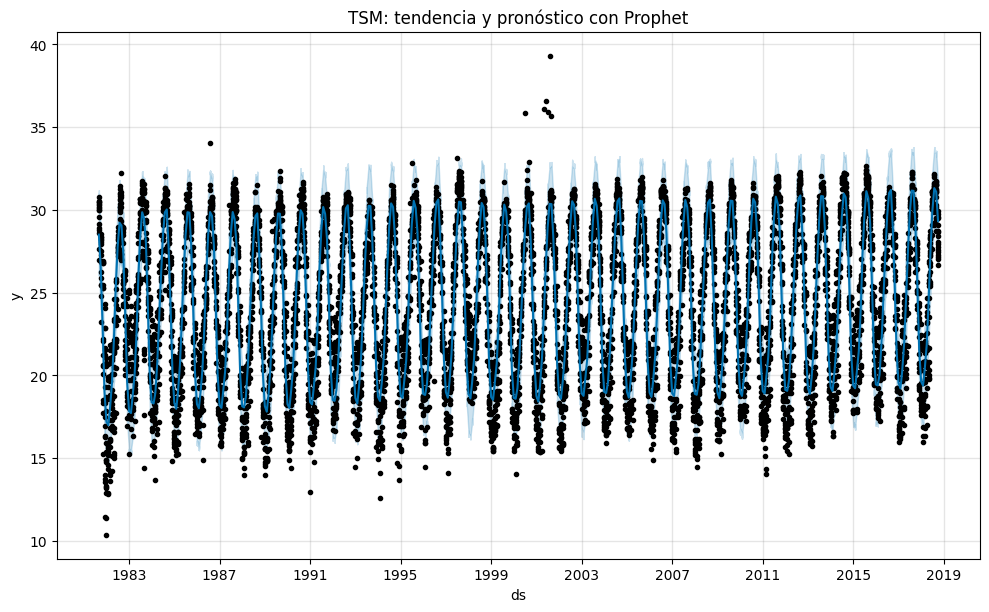

In [51]:
fig1 = model_tsm.plot(fcst_tsm)
plt.title("TSM: tendencia y pronóstico con Prophet")
plt.show()

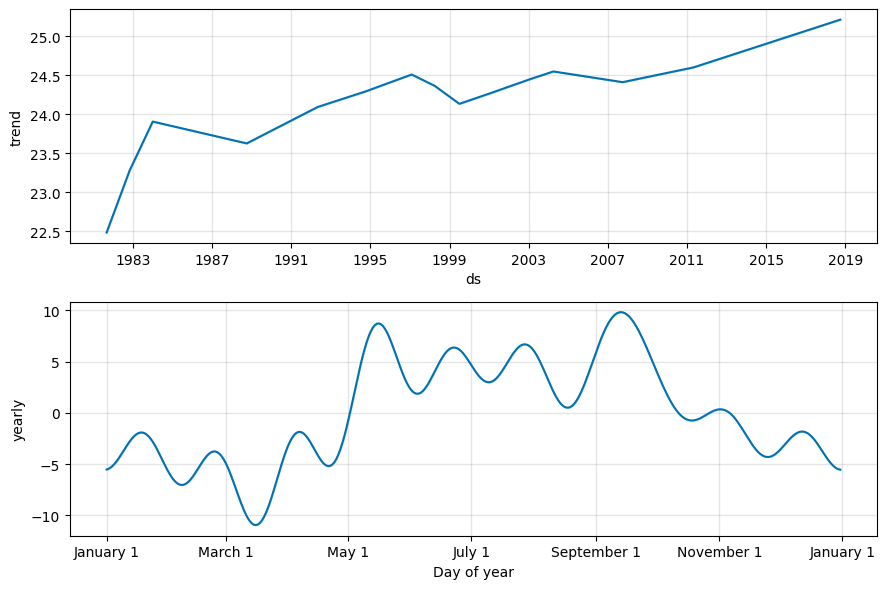

In [52]:
fig2 = model_tsm.plot_components(fcst_tsm)
plt.show()

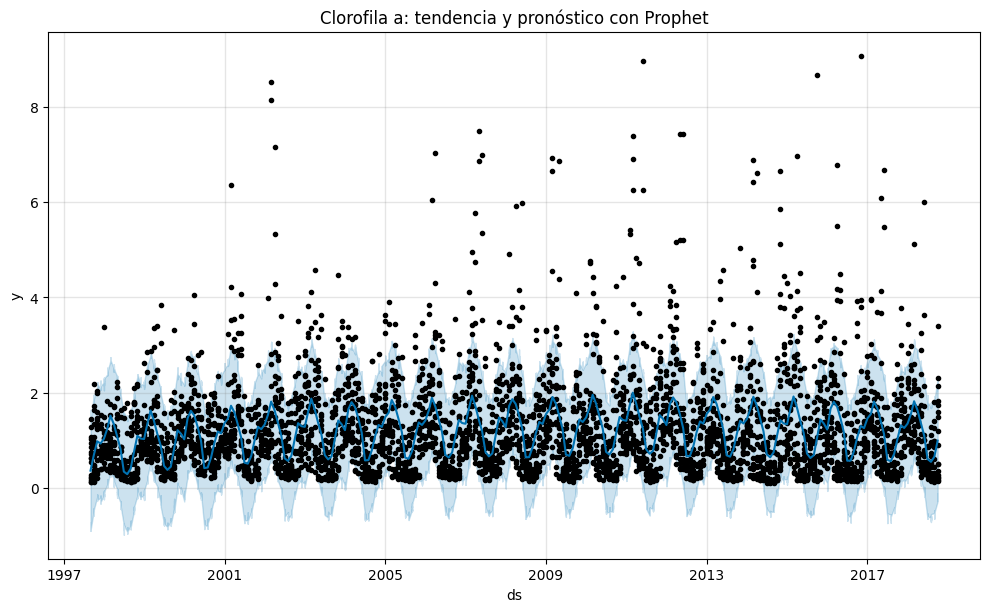

In [53]:
fig3 = model_chla.plot(fcst_chla)
plt.title("Clorofila a: tendencia y pronóstico con Prophet")
plt.show()

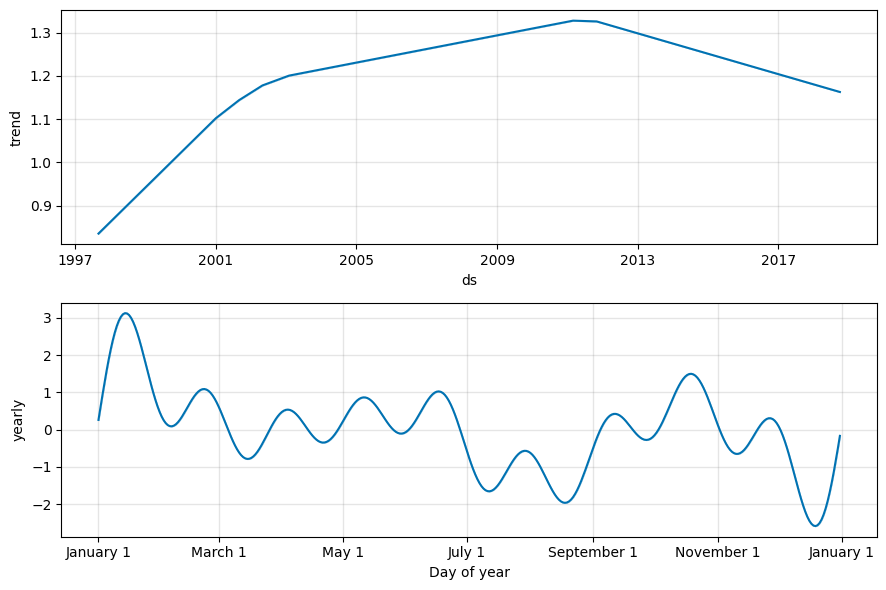

In [ ]:
fig4 = model_chla.plot_components(fcst_chla)
plt.show()